In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
labels = pd.read_csv('Dataset/rsna_heart_detection.csv')

In [3]:
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [4]:
ROOT_PATH = Path('Dataset/stage_2_train_images')
SAVE_PATH = Path('Processed-Heart-Detection')
SAVE_PATH.mkdir(parents=True, exist_ok=True)

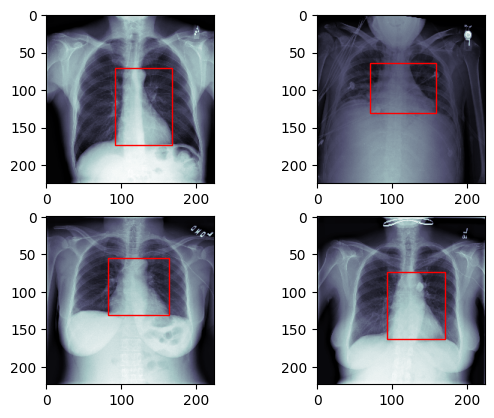

In [5]:
fig, axis = plt.subplots(2, 2)
c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        patient_id = data['name']
        dcm_path = ROOT_PATH / str(patient_id)
        dcm_path = dcm_path.with_suffix('.dcm')

        dcm = pydicom.read_file(dcm_path)
        dcm_array = dcm.pixel_array
        dcm_array = cv2.resize(dcm_array, (224, 224))

        x = data['x0']
        y = data['y0']
        width = data['w']
        height = data['h']

        axis[i][j].imshow(dcm_array, cmap='bone')
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        axis[i][j].add_patch(rect)
        c += 1


In [6]:
sums, sums_squared = 0, 0
train_ids = []
val_ids = []

for counter, patient_id in enumerate(list(labels.name)):
    dcm_path = ROOT_PATH / str(patient_id)
    dcm_path = dcm_path.with_suffix('.dcm')
    
    # Loading and Normalizing data
    dcm = pydicom.read_file(dcm_path).pixel_array / 255
    # Resizes the image to match the input size expected by ResNet18(224, 224)
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    # Separating train and validation sets
    train_or_val = 'train' if counter < 400 else 'val'
    
    # Saving train or val labels as lists
    if train_or_val == 'train':
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)
        
    #Saving files
    current_save_path = SAVE_PATH / train_or_val
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path / patient_id, dcm_array)

    # Normalizing pixel arrays
    normalizer = 224 * 224
    if train_or_val == 'train':
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer


In [7]:
# Saving train or val labels as files for future use
np.save('Processed-Heart-Detection/train_subjects', train_ids)
np.save('Processed-Heart-Detection/val_subjects', val_ids)

In [8]:
# Calculating mean and std for normalization in Model-Training
mean = sums / len(train_ids)
std = np.sqrt((sums_squared/len(train_ids))-mean**2)

In [9]:
mean, std

(0.49465999681122425, 0.25283820990181194)